# Extracting Velocity Based on Contrast Dispersion in Grafts


In [1]:
import vtk
import glob as glob_module
import os
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from scipy.stats import linregress
from scipy.integrate import odeint
from scipy.interpolate import CubicSpline, interp1d
import matplotlib.cm as cm
from vtk.util.numpy_support import vtk_to_numpy, numpy_to_vtk
from utilities import *

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'

In [2]:
path_ = "/Users/ana/Documents/AnahitaSeresti/06_ContrastDispersion/3_VesselProjection/VA02B/SVG_RCA"
graft_name = "SVG_RCA"
vtu_file_ = os.path.join(path_,f"{graft_name}.vtu")
centerline_file_ = os.path.join(path_, f"{graft_name}.pth")
Image_directory_ = "/Users/ana/Documents/AnahitaSeresti/06_ContrastDispersion/1_CTPImages/VA02B/CTP"
Image_names = sorted(glob_module.glob(f"{Image_directory_}/*.vtk"))
Territory_Labels = glob_module.glob(f"{path_}/../*.dat")[0]
Territory_Map = glob_module.glob(f"{path_}/../*.vtu")[0]
heart_rate = 60

In [3]:
tag = "post_rca"
id_values = []
with open(Territory_Labels, "r") as ifile:
    for i, LINE in enumerate(ifile):
        if i == 0: 
            continue
        line = LINE.strip().split()
        label = line[1]
        id_value = int(line[0])

        if tag in label.lower():
            id_values.append(id_value)

MBF = ReadVTUFile(Territory_Map)

for i in range(MBF.GetPointData().GetNumberOfArrays()):
    if "territory" in MBF.GetPointData().GetArrayName(i).lower():
        TerritoryArrayName = MBF.GetPointData().GetArrayName(i)
    elif "scalar" in MBF.GetPointData().GetArrayName(i).lower():
        MBFScalarArrayName = MBF.GetPointData().GetArrayName(i)

DownstreamTerritory = vtk.vtkAppendFilter()
for id in id_values:
    territory = ThresholdInBetween(MBF, TerritoryArrayName, id, id)
    DownstreamTerritory.AddInputData(territory)
DownstreamTerritory.Update()
DownstreamTerritory = DownstreamTerritory.GetOutput()

WriteVTUFile(os.path.join(path_,"DownstreamTerritory.vtu"), DownstreamTerritory)

In [4]:
def ConvertPointDataToCellData(PointData):
    PointToCell = vtk.vtkPointDataToCellData()
    PointToCell.SetInputData(PointData)
    PointToCell.Update()

    return PointToCell.GetOutput()

In [41]:
NCells = DownstreamTerritory.GetNumberOfCells()
DownstreamTerritory_celldata = ConvertPointDataToCellData(DownstreamTerritory)

voxel = DownstreamTerritory_celldata.GetCell(1)
cell_bounds = voxel.GetBounds()
VoxelVolume = abs(cell_bounds[0] - cell_bounds[1]) * abs(cell_bounds[2] - cell_bounds[3]) * abs(cell_bounds[4] - cell_bounds[5])

ScalarCellArray = vtk_to_numpy(DownstreamTerritory_celldata.GetCellData().GetArray(MBFScalarArrayName))
DownstreamFlowArray = VoxelVolume*ScalarCellArray/100
DownstreamFlow = DownstreamFlowArray.sum()
print(DownstreamFlow, "mL/min")



10.951716 mL/min


In [40]:
# make sure that MBF spacing is in cm
print(abs(cell_bounds[0] - cell_bounds[1]))
print(abs(cell_bounds[2] - cell_bounds[3]))
print(abs(cell_bounds[4] - cell_bounds[5]))

0.0390625
0.0390625
0.1999969482421875


### Project Images to the Mesh

In [6]:
def ProbeFilter(TargetData, SourceData):
    ProbeFilter=vtk.vtkProbeFilter()
    ProbeFilter.SetInputData(TargetData)
    ProbeFilter.SetSourceData(SourceData)
    ProbeFilter.Update()
    
    return ProbeFilter.GetOutput()

In [7]:
os.path.splitext(os.path.basename(Image_names[0]))[0]

'VA02B_01'

In [8]:
Mesh = ReadVTUFile(vtu_file_)
MeshProjections = {}
for image_name in Image_names:
    Image_ = ReadVTKFile(image_name)
    mesh_projection = ProbeFilter(Mesh, Image_)
    image_root_name = os.path.splitext(os.path.basename(image_name))[0]
    mesh_name = f"{graft_name}_{image_root_name}"
    MeshProjections[image_root_name] = mesh_projection
    WriteVTUFile(os.path.join(path_,f"{mesh_name}.vtu"), mesh_projection)

### Read SimVascular Pathline Annotations

In [9]:
with open(centerline_file_, "r") as path:
    #path.readlines()
    tree = ET.parse(path)
root = tree.getroot()

direction_points = []
for direction_point in root.findall(".//path_point/tangent"):
    x = float(direction_point.attrib['x'])
    y = float(direction_point.attrib['y'])
    z = float(direction_point.attrib['z'])
    direction_points.append((x,y,z))

position_points = []
for path_point in root.findall(".//path_point/pos"):
    x = float(path_point.attrib['x'])
    y = float(path_point.attrib['y'])
    z = float(path_point.attrib['z'])
    position_points.append((x,y,z))

path_normals = []
for normal in root.findall(".//path_point/rotation"):
    x = float(normal.attrib['x'])
    y = float(normal.attrib['y'])
    z = float(normal.attrib['z'])
    path_normals.append((x,y,z))

NPoints = len(position_points)
print("the number of points in the centerline is:", NPoints)

binormal = []
for i in range(NPoints):
    binormal_ = np.cross(np.array(direction_points[i]),np.array(path_normals[i]))
    binormal_ /= np.linalg.norm(binormal_)
    binormal.append(binormal_)
    

the number of points in the centerline is: 106


### Interpolation of the pathline

Need to interpolate the pathline to get equi-distance points.

pipeline: 
 - use a cubic spline with a fine resolution. (10000 points).
 - undersample it to get points every 0.5 or 1 mm. Depending on the spacing.

 or:
 - interpolate on x, y, and z separately.

In [10]:
cumulative_distance = [0]
for i in range(1, NPoints):
    dist_ = np.sqrt((position_points[i][0] - position_points[i-1][0])**2 +
                    (position_points[i][1] - position_points[i-1][1])**2 +
                    (position_points[i][2] - position_points[i-1][2])**2 )
    cumulative_distance.append(dist_ + cumulative_distance[i-1])


In [11]:
# interpolating on x, y, and z separately

spacing = 1 #mm
#new_distances = [0]
new_distances = [i + spacing for i in range(int(max(cumulative_distance)))]#.extend()

#>>> interpolating the position points
x = np.zeros(len(position_points))
y = np.zeros(len(position_points))
z = np.zeros(len(position_points))

for i, point in enumerate(position_points):
    (x_, y_, z_) = point
    x[i] = point[0]
    y[i] = point[1]
    z[i] = point[2]

f_cubic_x = interp1d(cumulative_distance, x, kind="cubic")
f_cubic_y = interp1d(cumulative_distance, y, kind="cubic")
f_cubic_z = interp1d(cumulative_distance, z, kind="cubic")

x_interp = f_cubic_x(new_distances)
y_interp = f_cubic_y(new_distances)
z_interp = f_cubic_z(new_distances)


new_position_points = []
for i in range(len(new_distances)):
    new_position_points.append((x_interp[i], y_interp[i], z_interp[i]))


#>>> interolating the direction points
x = np.zeros(len(direction_points))
y = np.zeros(len(direction_points))
z = np.zeros(len(direction_points))


for i, point in enumerate(direction_points):
    (x_, y_, z_) = point
    x[i] = point[0]
    y[i] = point[1]
    z[i] = point[2]

f_cubic_x = interp1d(cumulative_distance, x, kind="cubic")
f_cubic_y = interp1d(cumulative_distance, y, kind="cubic")
f_cubic_z = interp1d(cumulative_distance, z, kind="cubic")

x_interp = f_cubic_x(new_distances)
y_interp = f_cubic_y(new_distances)
z_interp = f_cubic_z(new_distances)


new_direction_points = []
for i in range(len(new_distances)):
    new_direction_points.append((x_interp[i], y_interp[i], z_interp[i]))
    


### Convert Pathline to VTP

In [12]:
def points_to_vtp(points):
    # Create VTK points
    vtk_points = vtk.vtkPoints()
    for point in points:
        vtk_points.InsertNextPoint(point)

    # Create a polyline
    polyline = vtk.vtkPolyLine()
    polyline.GetPointIds().SetNumberOfIds(len(points))
    for i in range(len(points)):
        polyline.GetPointIds().SetId(i, i)

    # Create a cell array to store the polyline
    cells = vtk.vtkCellArray()
    cells.InsertNextCell(polyline)

    # Create a polydata object
    polydata = vtk.vtkPolyData()
    polydata.SetPoints(vtk_points)
    polydata.SetLines(cells)

    return polydata

In [13]:
centerline_vtp = points_to_vtp(position_points)
new_centerline_vtp = points_to_vtp(new_position_points)
WriteVTPFile(os.path.join(path_, "new_centerline.vtp"), new_centerline_vtp)
peak_intensity = 5
image_ = ReadVTKFile(Image_names[peak_intensity])

### split the vessel to the upper and lower segments
splitting into two halves along the z-axis.

In [14]:
def gradient_filter(vtk_image):
    gradient_filter = vtk.vtkImageGradient()
    gradient_filter.SetInputData(vtk_image)
    gradient_filter.SetDimensionality(3)
    gradient_filter.Update()

    return gradient_filter.GetOutput()
    
def define_borders(gradient_image):
    magnitude_filter = vtk.vtkImageMagnitude()
    magnitude_filter.SetInputData(gradient_image)
    magnitude_filter.Update()
    
    return magnitude_filter.GetOutput()

In [15]:
def clip_polydata_with_plane(polydata, origin, normal, inside_out=False):
    plane = vtk.vtkPlane()
    plane.SetOrigin(origin)
    plane.SetNormal(normal)

    clipper = vtk.vtkClipPolyData()
    clipper.SetInputData(polydata)
    clipper.SetClipFunction(plane)

    if inside_out:
        clipper.InsideOutOn()
    else:
        clipper.InsideOutOff()
    
    clipper.Update()

    return clipper.GetOutput()

def clip_USGrid_w_plane(USGrid, origin, normal, inside_out = False):
    plane = vtk.vtkPlane()
    plane.SetOrigin(origin)
    plane.SetNormal(normal)

    clipper = vtk.vtkClipDataSet()
    clipper.SetInputData(USGrid)
    clipper.SetClipFunction(plane)

    if inside_out:
        clipper.InsideOutOn()
    else:
        clipper.InsideOutOff()
    
    clipper.Update()

    return clipper.GetOutput()

In [16]:
x_min = image_.GetBounds()[0]
x_max = image_.GetBounds()[1]

y_min = image_.GetBounds()[2]
y_max = image_.GetBounds()[3]

z_min = image_.GetBounds()[4]
z_max = image_.GetBounds()[5]

center_point = [
    (x_max + x_min)/2,
    (y_max + y_min)/2,
    (z_max + z_min)/2
]
z_axis = [0,0,1]

### Cutting the lumen at each cenreline point

In [17]:
def slice_w_plane(Volume,Origin,Norm):
    plane=vtk.vtkPlane()
    plane.SetOrigin(Origin)
    plane.SetNormal(Norm)
    Slice=vtk.vtkCutter()
    Slice.GenerateTrianglesOff()
    Slice.SetCutFunction(plane)
    Slice.SetInputData(Volume)
    Slice.Update()
    return Slice.GetOutput()

In [18]:
def SphereClip(volume_image,center,radius):
    sphere = vtk.vtkSphere()
    sphere.SetCenter(center)
    sphere.SetRadius(radius)

    clipper = vtk.vtkClipDataSet()
    clipper.SetInputData(volume_image)
    clipper.SetClipFunction(sphere)
    clipper.InsideOutOn()
    clipper.GetOutputInformation(1)
    clipper.Update()

    return clipper.GetOutput()

In [19]:
def GetSurfaceArea(polydata):
    properties = vtk.vtkMassProperties()
    properties.AddInputData(polydata)
    properties.Update()
    return properties.GetSurfaceArea()

In [20]:
def LumenCrossSections(mesh, centreline, ScalarArrayName):
    """takes the lumen and the centreline of that lumen and projects the cross_sectional average on the centreline.

    Args:
        mesh (_type_): _description_
        centerline (_type_): _description_

    Returns:
        _type_: _description_
    """

    CrossSections = vtk.vtkAppendPolyData()
    Area_ = []
    Average_Array = []
    for idx in range(len(new_position_points)):
        cross_section_ = slice_w_plane(mesh, new_position_points[idx], new_direction_points[idx])
        area_ = GetSurfaceArea(cross_section_)
        Area_.append(area_)
        radius = np.sqrt(area_/np.pi)
        inner_section_ = SphereClip(cross_section_, GetCentroid(cross_section_), radius*0.75)
        Average_Array.append(np.mean(vtk_to_numpy(inner_section_.GetPointData().GetArray(ScalarArrayName))))
        CrossSections.AddInputData(ExtractSurface(inner_section_))
    CrossSections.Update()
    Area = np.mean(np.array(Area_))
    Average_Array_vtk = numpy_to_vtk(np.array(Average_Array))
    Average_Array_vtk.SetName(ScalarArrayName)
    centreline.GetPointData().AddArray(Average_Array_vtk)
    #WriteVTPFile(os.path.join(path_, "CrossSections.vtp"), CrossSections.GetOutput())

    return CrossSections.GetOutput(), centreline, Area

In [22]:

UpperMeans = np.zeros((100,100))
LowerMeans = np.zeros((100,100))
ScalarArrayName = image_.GetPointData().GetArrayName(0)

for i, (key, mesh) in enumerate(MeshProjections.items()):
    csection, centreline_, Area = LumenCrossSections(mesh, new_centerline_vtp, ScalarArrayName)
    upper_mesh = clip_polydata_with_plane(csection, center_point, z_axis, True)
    centerline_upper = clip_polydata_with_plane(centreline_, center_point, z_axis, True)
    mesh_name_upper = f"{graft_name}_{key}_upper"
    if upper_mesh.GetNumberOfPoints() != 0:
        WriteVTPFile(os.path.join(path_,f"{mesh_name_upper}.vtp"), upper_mesh)
        mean = vtk_to_numpy(centerline_upper.GetPointData().GetArray(ScalarArrayName))
        UpperMeans[:len(mean),i] = mean.T

    lower_mesh = clip_polydata_with_plane(csection, center_point, z_axis)
    centerline_lower = clip_polydata_with_plane(centreline_, center_point, z_axis)
    mesh_name_lower = f"{graft_name}_{key}_lower"
    if lower_mesh.GetNumberOfPoints() != 0:
        WriteVTPFile(os.path.join(path_,f"{mesh_name_lower}.vtp"), lower_mesh)
        mean = vtk_to_numpy(centerline_lower.GetPointData().GetArray(ScalarArrayName))
        LowerMeans[:len(mean),i] = mean.T


In [23]:
#removing zeros
UpperMeans = UpperMeans[~np.all(UpperMeans == 0, axis=1)]
UpperMeans = UpperMeans[:, ~np.all(UpperMeans == 0, axis=0)]
print(UpperMeans.shape)
LowerMeans = LowerMeans[~np.all(LowerMeans == 0, axis=1)]
LowerMeans = LowerMeans[:, ~np.all(LowerMeans == 0, axis=0)]
print(LowerMeans.shape)

(82, 10)
(53, 10)


In [24]:
#>>> linear interpolation 
_, n_col = UpperMeans.shape

col_idx_old = np.arange(0, 2*n_col, 2)
col_idx_new = np.arange(0, 2*n_col - 1)

f = interp1d(col_idx_old, UpperMeans, kind="linear", axis=1)
UpperMeans_interp = f(col_idx_new)


f = interp1d(col_idx_old, LowerMeans, kind="linear", axis=1)
LowerMeans_interp = f(col_idx_new)

In [46]:
MeansArray = np.vstack([UpperMeans_interp[:,:-1], LowerMeans_interp[:,1:]]) # only if lower portion of image leads the upper one.
MeansArray_sum = np.sum(MeansArray, axis=0)
max_idx = np.argmax(MeansArray_sum)
C = MeansArray[:,max_idx + 1:] #C is the washout phase
C.shape

(135, 9)

In [47]:
# interpolate in time domain
beat_duration = 60/heart_rate

wo_time  = [2* i * beat_duration for i in range(C.shape[1])]
wo_time_interp = np.linspace(min(wo_time), max(wo_time),100)
f = interp1d(wo_time, C, kind="cubic", axis=1)
C_interp = f(wo_time_interp)
C_interp.shape

(135, 100)

In [48]:
x_new = np.linspace(0,C.shape[0],C.shape[0])
x_new.shape

(135,)

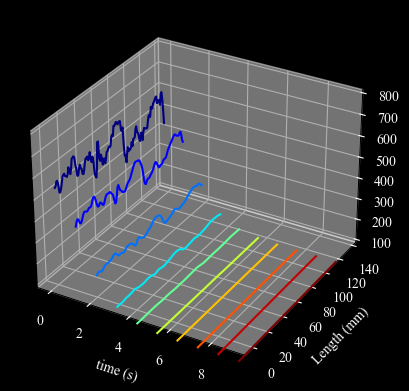

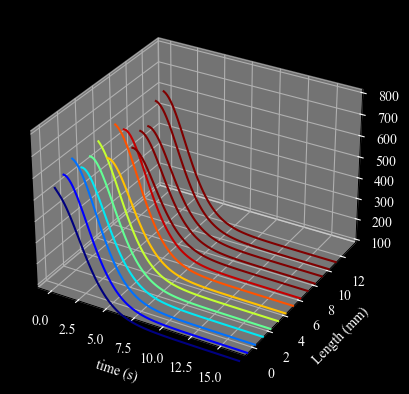

In [49]:
time = np.array(wo_time_interp)


Length = x_new.max() - x_new.min() #Length of domain
N = x_new.shape[0] #number of points along the x
dx = Length/(N - 1) #spatial differences
kappa = 2*np.pi*np.fft.fftfreq(N, dx)

D = 0.4 #diffusion coefficient

C0 = C_interp[:,0] #Contrast dispersion at the time of zero along the vessel
#C0 = np.zeros_like(x_new)
#C0[int((Length/2 - Length/10)/dx):int((Length/2 + Length/10)/dx)] = 1





C0hat = np.fft.fft(C0)
C0hat_ri = np.concatenate((C0hat.real, C0hat.imag))


# Implementing the diffusion part in frequency domain
def Diffusion(Chat_ri, t, kappa, D, k):
    Chat = Chat_ri[:N] + (1j) * Chat_ri[N:]
    d_Chat = - D * (np.power(kappa, 2)) * Chat - (1 - np.exp(-k * t)) * Chat #- 1j * v * kappa* Chat 
    d_Chat_ri = np.concatenate((d_Chat.real, d_Chat.imag)).astype('float64')
    return d_Chat_ri

Chat_ri = odeint(Diffusion, C0hat_ri, time, args=(kappa,D, 0.25)) # k is for the exponential decay and was selected by trial and error.

Chat = Chat_ri[:,:N] + (1j) * Chat_ri[:,N:]

C_Gaussian_filter = np.zeros_like(Chat)
for i in range(len(time)):
    C_Gaussian_filter[i,:] = np.fft.ifft(Chat[i,:])

C_Gaussian_filter = C_Gaussian_filter.real



fig = plt.figure(facecolor="black")
ax = fig.add_subplot(111, projection='3d', facecolor = "black")
plt.set_cmap('jet_r')
c_plot = C_Gaussian_filter[0:-1:10,:]
for k in range(c_plot.shape[0]):
    ys = k*np.ones(c_plot.shape[1])
    ax.plot(ys,x_new,c_plot[k,:], color = cm.jet(k*30))


ax.set_xlabel("time (s)")
ax.set_ylabel("Length (mm)")
ax.tick_params(colors="white")
ax.xaxis.label.set_color("white")
ax.yaxis.label.set_color("white")
ax.zaxis.label.set_color("white")
ax.set_zbound([100, 800])


fig = plt.figure(facecolor="black")
ax = fig.add_subplot(111, projection='3d', facecolor = "black")
plt.set_cmap('jet_r')
c_plot = C_Gaussian_filter[:,0:-1:10]
for k in range(c_plot.shape[1]):
    ys = x_new[k]*np.ones(c_plot.shape[0])
    ax.plot(time,ys,c_plot[:,k], color = cm.jet(k*30))


ax.set_xlabel("time (s)")
ax.set_ylabel("Length (mm)")
ax.tick_params(colors="white")
ax.xaxis.label.set_color("white")
ax.yaxis.label.set_color("white")
ax.zaxis.label.set_color("white")
ax.set_zbound([100, 800])


21.32672574626865 cm/s


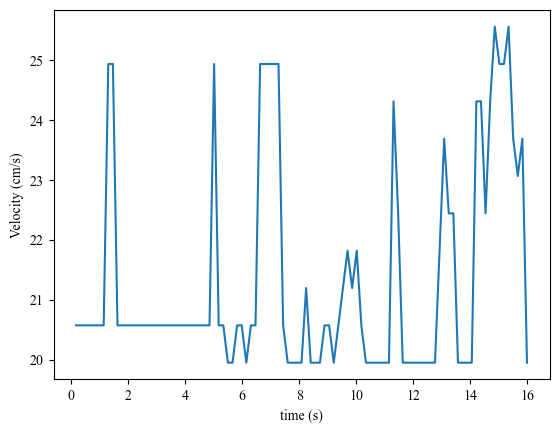

In [50]:

dt = (time.max()-time.min())/(len(time)-1)
Velocity = []
for t1 in range(1,len(time)):
    C0 = C_Gaussian_filter[t1,:]
    C1 = C_interp[t1,:]

    cross_corr = np.correlate(C0 , C1 , mode='full')
    idx = np.argmax(cross_corr)
    lag_sample = idx - (N//2)
    delta_x = lag_sample * dx
    velocity = delta_x/dt
    Velocity.append(velocity/10)

plt.figure()
plt.plot(time[1:], Velocity)
plt.ylabel("Velocity (cm/s)")
plt.xlabel("time (s)")

print(np.mean(np.array(Velocity)), "cm/s")

In [52]:
print(Area, "mm2")
velocity = np.mean(np.array(Velocity))
print(velocity, "cm/s")
Flow =  velocity * Area * 0.6  #mL/min
print(Flow, "mL/min")
print(2*np.sqrt(Area/np.pi))

1.7490543894684718 mm2
21.32672574626865 cm/s
22.38096196770087 mL/min
1.4923019850432


todo: add the figures for entire TAC along the vessel.